In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
import pandas as pd

In [4]:
import glob, os
import re

## File paths

In [5]:
glob_list = []

#loop through subject folders and glob
for subject in range(25):
    glob_list.append(glob.glob(str(subject) + "\\[A-Z0-9]*.csv"))
    
#function to flatten glob
flatten = lambda l: [item for sublist in l for item in sublist]
glob_list = flatten(glob_list)

In [6]:
#make a list of tuples of hand pairings
lr_pairs = list(zip(*[iter(glob_list)]*2))

# remove all blue files
for i in range(25):
    lr_pairs.remove((str(i)+'\\Blue_Left.csv', str(i)+'\\Blue_Right.csv'))
# remove "bad" from subject 19
lr_pairs.remove(('19\\Bad_Left.csv', '19\\Bad_Right.csv'))

## Create list of DataFrames

In [7]:
df_list = []

for pair in lr_pairs:
    df_left = pd.read_csv(pair[0], index_col=None).drop(['Unnamed: 0'], axis = 1)
    df_right = pd.read_csv(pair[1], index_col=None).drop(['Unnamed: 0'], axis = 1)
    
    #rename columns
    df_left = df_left.add_prefix('left')
    df_right = df_right.add_prefix('right')
    
    #merge
    df = pd.merge(df_left, df_right, left_on='leftTime', right_on='rightTime').drop('rightTime', axis = 1)

    #covert fist column to time object
    df['leftTime'] = pd.to_datetime(df['leftTime'].str[:-3], format = '%H:%M:%S.%f')
    
    #difference between rows
    df = df.diff().iloc[1:]
    df['leftTime'] = df['leftTime'].dt.total_seconds()
    
    df.rename(columns={'leftTime':'time'}, inplace=True)
    
    #add sign and subject using regex of file name
    subject_sign = re.split(r'\\', re.findall('^[^_]+(?=_)', pair[0])[0])
    df.insert(loc = 0, column = 'Subject', value = subject_sign[0])
    df.insert(loc = 0, column = 'Sign', value = subject_sign[1])
    
#this makes velocity columns

#     for col in df.iloc[:,2:]:
#         df[col + ' velocity'] = df[col]/df['Time']
    
    df_list.append(df)

## Hand Classification

In [3]:
hands_used  = pd.read_csv("signs_f.csv")
two_hand = hands_used[hands_used.Both_Hands.notnull()].Sign.values
one_hand = hands_used[hands_used.Both_Hands.isnull()].Sign.values

In [56]:
class hand_selection:
    
    def __init__(self, drop_left=False):
        self.drop_left = drop_left
        
    def transform(self, df_list, hand_list):
        if not self.drop_left:
            subset = [df for df in df_list if df.Sign.values[0] in hand_list]
        else:
            subset = [df.drop(df.filter(regex='left').columns, axis=1) \
                      for df in df_list \
                      if df.Sign.values[0] in hand_list]
            
        return subset

## Feature Extraction

In [54]:
class extraction:
    def __init__(self, df):
        self.df = df
        self.features = dict()
        
    def label(self):
        self.features['label'] = self.df['Sign'].iloc[0]
        self.df = self.df.iloc[:, 2:]
        
    def mean(self):
        for col in self.df:
            self.features[col + ' mean'] = self.df[col].mean()
            
    def stdev(self):
        for col in self.df:
            self.features[col + ' stdev'] = self.df[col].std()
            
    def extract_features(self):
        self.label()
        self.mean()
        self.stdev()

In [95]:
from sklearn.preprocessing import StandardScaler

def return_features(df_list, hand_list, drop_left):
    scaler = StandardScaler()
    
    feature_list = []
    
    select_class = hand_selection(drop_left)
    frames = select_class.transform(df_list, hand_list)
    
    for df in frames:
        class_obj = extraction(df)
        class_obj.extract_features()
        feature_list.append(class_obj.features)
        
    feat_df = pd.DataFrame(feature_list)
    
    y = feat_df.label
    X = scaler.fit_transform(feat_df.drop(['label'], axis = 1))
    
    return X, y

In [96]:
X_one_hand, y_one_hand = return_features(df_list=df_list, 
                                         hand_list=one_hand, 
                                         drop_left=True)

X_two_hand, y_two_hand = return_features(df_list=df_list, 
                                         hand_list=two_hand, 
                                         drop_left=False)

## Model

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Two Hand

In [105]:
import warnings
warnings.filterwarnings('ignore')

accuracy = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                        y_two_hand,
                                                        stratify=y_two_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    #clf.scalings_
    accuracy.append(clf.score(X_test,y_test))

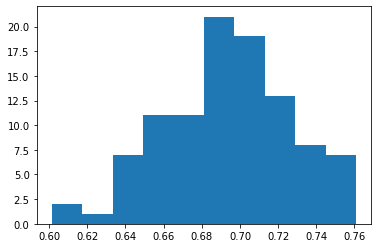

In [106]:
plt.hist(accuracy, bins=10)
plt.show()

### One Hand

In [99]:
accuracy = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                        y_one_hand,
                                                        stratify=y_one_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    #clf.scalings_
    accuracy.append(clf.score(X_test,y_test))

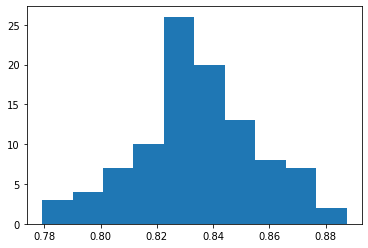

In [102]:
plt.hist(accuracy, bins=10)
plt.show()